In [2]:
import numpy as np
import pandas as pd
import random
import time

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import xgboost as xgb



import seaborn as sns
%matplotlib inline

from datetime import datetime, timedelta, date

## Structure of the algorithm

The following code is divided in two classes namely, 

- ConsumptionModel
- Simulator

Consumption model primarily consists of the functions related to the basic machine learning model which predicts the dynamic user behaviour

In [3]:
# The dict 'params' consists of all the parameters used in the simulation software for ease of alteration
params = {
#         Set the regression model related parameters
          'train_start_dt':'2013-01',
          'train_stop_dt':'2013-09',
          'y_variable': 'trial_d',
          'X_variables':['trial_n', 'low', 'normal', 'high', 'WIND_DIRECTION', 'WIND_SPEED', 'VISIBILITY', 'MSL_PRESSURE',
                         'AIR_TEMPERATURE', 'DEWPOINT', 'WETB_TEMP', 'STN_PRES', 'WMO_HR_SUN_DUR', 'hour', 'day'],
    
#         Set XGBoost regression parameters (for consumption model)
          'n_estimators': 50,
          'early_stopping_rounds': 50,  #stop if 50 consequent rounds without decrease of error
          'verbose': False,             # Change verbose to True if you want to see it train
          'nthread': 4,
    
#         Set simulator parameters to default values
          'season': 0,
          'day_of_week': 0,
          'special_event': 0,
          'tariff_policy':[],
    
#         Set Occupant behaviour dynamics
          'user_engagement': 0,     # Set the % of users who are willing to engage in the experiments
          'participation': 0,       # Set the % of users who will be available to participate in specific experiment
          'user_latency': 0         # Set the values which correspond to real life participation delay for users 
         }

In [4]:
class ConsumptionModel(object):
    def __init__(self, df, params):
        self.df = df
        self.params = params
#         some variables

    def prep_data(self):
        self.df = self.df.dropna().copy()
        one_hot= pd.get_dummies(self.df['tariff'])
        one_hot_renamed = one_hot.rename(index=str, columns={0.0399:'low', 0.1176:'normal', 0.672:'high'}) 
        self.df = self.df.join(one_hot_renamed).drop('tariff', axis=1)
        
        self.df["hour"] = self.df.index.hour
        self.df["day"] = self.df.index.day
        self.df["month"] = self.df.index.month


    
    def train(self):
#         Complete the xgboost model on 2013 data
        self.X_train = self.df.loc[self.params["train_start_dt"]:self.params["train_stop_dt"],self.params["X_variables"]]
        self.y_train = self.df.loc[self.params["train_start_dt"]:self.params["train_stop_dt"],self.params["y_variable"]]
        self.X_test = self.df.loc[self.params["train_stop_dt"]:,self.params["X_variables"]]
        self.y_test = self.df.loc[self.params["train_stop_dt"]:,self.params["y_variable"]]

        self.xg_reg = xgb.XGBRegressor(n_estimators=self.params['n_estimators'], nthread = self.params["nthread"])
        self.xg_reg.fit(self.X_train, self.y_train,
                        eval_set=[(self.X_train, self.y_train), (self.X_test, self.y_test)],
                        early_stopping_rounds = self.params["early_stopping_rounds"],
                        verbose = self.params["verbose"])

#         Get feature importance chart
        return xgb.plot_importance(self.xg_reg, height=0.9) # Plot feature importance
      

    def test(self, X_test):
#         test the data points. Get the predictions
        self.preds = self.xg_reg.predict(X_test)

    def entropy(self):
#         get entropy of each data point nad return the entropy dataframe
        pass


In [ ]:
# from datetime import date
# import random

# start_dt = date.today().replace(day=1, month=1, year=2013).toordinal()
# end_dt = date.today().toordinal()
# random_day = date.fromordinal(random.randint(start_dt, end_dt))
# print(start_dt)

In [ ]:
# df_final.index[1000].dayofweek

In [ ]:
### Playground cell

# month = 3
# dow = 4

# random.choice(df_final.loc[(df_final.index.month == month) & (df_final.index.dayofweek == dow), :].index.year)
# day = 4
# year = 2013
# # timestamp = sample.index.strftime("%Y-%m-%d").format() #pd.to_datetime(sample.index.strftime("%Y-%m-%d"))
# # df_final.loc[timestamp,:]
# # timestamp = sample.index.strftime("%Y-%m-%d").format()
# # sample.values
# # a = "2013-03-22"
# date = str(year)+"-"+str(month)+"-"+str(day)
# df_final.loc[a,:]
# # len(df_final.columns)

In [12]:
class Simulator:
    
    def __init__(self, df, params):
        self.params = params
        self.df = df
        self.spring = [3, 4, 5]
        self.summer = [6, 7, 8]
        self.autumn = [9, 10, 11]
        self.winter = [1, 2, 12]


    def select_day(self):        
#         Select the season
        if self.params["season"] == 0:
            month = random.randrange(1,12)
        elif self.params["season"] == 1:
            month = random.choice(self.spring)
        elif self.params["season"] == 2:
            month = random.choice(self.summer)
        elif self.params["season"] == 3:
            month = random.choice(self.autumn)
        elif self.params["season"] == 4:
            month = random.choice(self.winter)

            
#         Select the day of week
        if self.params["day_of_week"] == 0:
#             Select random day
            dow = random.randrange(0,7)
        else:
            dow = self.params["day_of_week"] - 1
            
#         Select the random day from the entries which satisfy above conditions
        shortlist = self.df.loc[(self.df.index.month == month) & (self.df.index.dayofweek == dow), :].index
        day = random.choice(shortlist.day.values)
        year = random.choice(shortlist.year.values)
        timestamp = str(year)+"-"+str(month)+"-"+str(day)
        self.sample = self.df.loc[timestamp,:]
        
        
        
    def random_day(self):
        shortlist = self.df.sample(axis = 0).index
        day = random.choice(shortlist.day.values)
        month = random.choice(shortlist.month.values)
        year = random.choice(shortlist.year.values)
        timestamp = str(year)+"-"+str(month)+"-"+str(day)
        self.sample = self.df.loc[timestamp,:]
        
        
        
    def auto_noise_addition(self, levels, constraints):
#         select the random users and their behaviour with random latency

        for instances in constraints[""]
        self.noisy_tariff["h1_start"] = random.sample(xrange(constraints["h1_start"]*constraints["freq_per_hr"]-2, constraints["h1_start"]*constraints["freq_per_hr"]+5), len(self.df.columns))
        self.noisy_tariff["h1_end"] = random.sample(xrange(constraints["h1_end"]*constraints["freq_per_hr"]-4, constraints["h1_end"]*constraints["freq_per_hr"]+2), len(self.df.columns))
    

    def tariff_policy(self, levels, constraints):
#         use variables from auto_noise_addition and input variables of this function to create a tariff policy 
#         for each participating user **REQUIRES TIME AND BRAIN**
        self.auto_noise_addition(levels,contraints)
        
    def run(self):
#         FOR EACH USER, call test function of consumption model, get modified behaviour, return original data point and modified data point
        pass

In [ ]:
sim = Simulator(df_final,params)
sim.random_day()
sim.sample

In [ ]:
# Make a dictionary similar to but not limited to following dictionary
# selection_vars = {"season":"1-to-4", "DoW":"1-to-7", "special_day":"select holiday/event", "tariff_policy":"24-hour-policy-list"}

class select_next(object):
    
    def __init__(self, params):
        self.params = {"season":, "DoW":, "special_event":, "tariff_policy":}
    
    
    def random_day(self):
#         select the variables randomly, put them in self.datetime dictionary and call _datetime function 

    
    
    def specific_day(self, season, dow, event):
#         add the provided variables and call _datetime function also include the randomness
        
    def select_day(self, datetime):
#         add the provided variables and call _datetime function also include the randomness
#         return the selected datetime details
        
    def tariff_policy(self, levels, constraints):
        
        
    

In [7]:
df=pd.read_csv('../mod_datasets/aggregate_consumption.csv', sep=',', header=0, index_col=0, parse_dates=['GMT'], low_memory=False)
df = df.drop_duplicates()
df_midas=pd.read_csv('../mod_datasets/midas_weather.csv', sep=',', header=0, index_col=0, parse_dates=['GMT'], low_memory=False)
df_midas_rs = df_midas.resample('30T').mean()
df_interpolated = df_midas_rs.interpolate(method='linear')
df_weather = df_interpolated.loc['2013-01':'2013-12',:]
df_final = pd.concat([df,df_weather], axis=1)

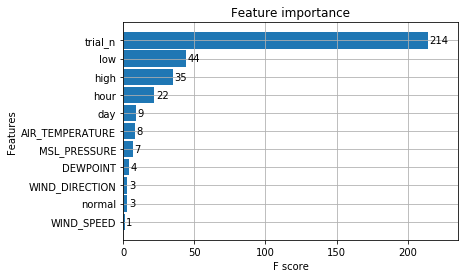

In [8]:
consumption_model = ConsumptionModel(df_final, params)
consumption_model.prep_data()
consumption_model.train()

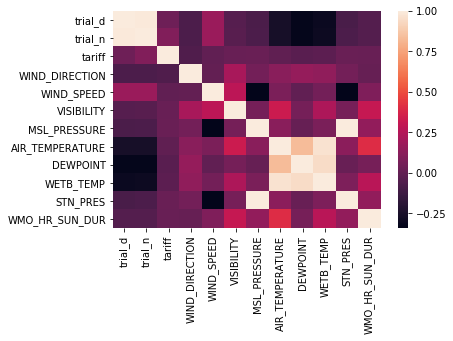

In [9]:
corr = df_final.corr()
sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns)